In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v2', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v2')

     |████████████████████████████████| 3.8MB 5.7MB/s 


In [3]:
train_ds, test_ds = ds['train'], ds['test']

In [4]:
import tensorflow as tf

@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label 

In [5]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [6]:
batch_size = 32
buffer_size = 1000

train_ds = train_ds.cache().shuffle(buffer_size).batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
img_shape = (224, 224, 3) 
mobilenet = tf.keras.applications.MobileNet(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet'
)

17227776/17225924 [==============================] - 0s 0us/step


In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [14]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [15]:
def get_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = mobilenet(inputs)
  x = global_average_layer(x)
  outputs = prediction_layer(x)
  
  return tf.keras.Model(inputs, outputs)

In [16]:
model = get_model()
lr = 3e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [17]:
len(model.trainable_variables)

83

In [18]:
init_loss, init_acc, init_prec, init_recall = model.evaluate(test_ds)

4/4 [==============================] - 18s 45ms/step - loss: 0.7409 - accuracy: 0.4850 - precision: 0.7352 - recall: 0.1945


In [19]:
print(f"initial loss: {init_loss}")
print(f"initial accuracy: {init_acc}")
print(f"initial precision: {init_prec}")
print(f"initial recall: {init_recall}")

initial loss: 0.7544620037078857
initial accuracy: 0.46000000834465027
initial precision: 0.7142857313156128
initial recall: 0.1666666716337204


In [20]:
epochs = 30
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=test_ds)

Epoch 1/30
30/30 [==============================] - 8s 122ms/step - loss: 0.1416 - accuracy: 0.9486 - precision: 0.9645 - recall: 0.9709 - val_loss: 2.7049 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
30/30 [==============================] - 3s 112ms/step - loss: 0.0057 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6768 - val_accuracy: 0.4100 - val_precision: 1.0000 - val_recall: 0.0167
Epoch 3/30
30/30 [==============================] - 3s 111ms/step - loss: 0.0015 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.2210 - val_accuracy: 0.5000 - val_precision: 1.0000 - val_recall: 0.1667
Epoch 4/30
30/30 [==============================] - 3s 111ms/step - loss: 7.8535e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4381 - val_accuracy: 0.7800 - val_precision: 1.0000 - val_recall: 0.6333
Epoch 5/30
30/30 [==============================] - 3s 111ms/step - loss: 6.5164e-04 - accur

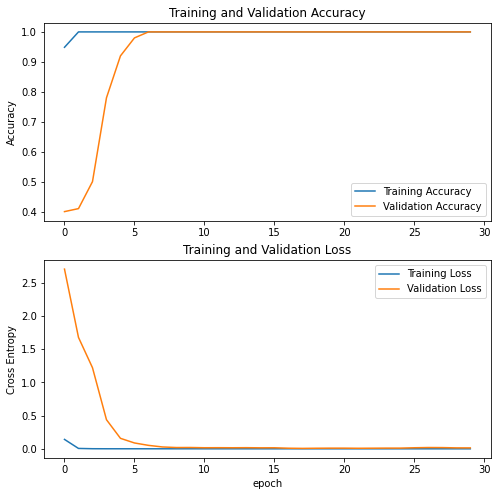

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

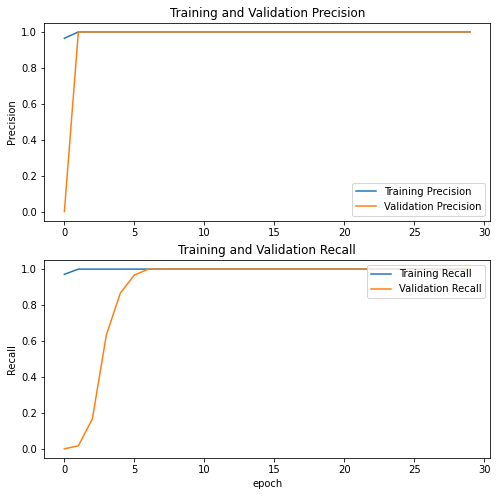

In [22]:
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()

In [48]:
pred = model.predict(test_ds.take(1))
print(pred)

[[9.9986959e-01]
 [9.9956757e-01]
 [7.0606186e-03]
 [7.0593722e-02]
 [9.9984360e-01]
 [9.4656851e-03]
 [9.9996233e-01]
 [9.9998534e-01]
 [9.9992752e-01]
 [9.9440032e-01]
 [9.9999714e-01]
 [1.8788136e-05]
 [9.9952590e-01]
 [6.5459404e-03]
 [3.9398871e-04]
 [9.9996638e-01]
 [1.5438252e-04]
 [2.0550057e-02]
 [9.9992299e-01]
 [9.9991918e-01]
 [9.9998224e-01]
 [9.9753052e-01]
 [6.0452700e-02]
 [9.9998784e-01]
 [3.9513418e-03]
 [9.9994290e-01]
 [6.5614483e-03]
 [4.0608556e-05]
 [3.3136865e-04]
 [7.2554959e-04]
 [9.9997735e-01]
 [9.4646883e-01]]
